As of we know RL is used to train robots and drones for matrix multiplication, also chatgpt was trained. No data is fed, our agent goes to the real environment and learns through it itself. Double Deep Q network is implemented 

Our agent today is Neural Network that will be controlling our Mario, it is responsible for making decisions and taking the optimal actions based on the decisions. 
We will be implementing level 1-1 which is our environment.

state: A snapshot of an environment at any given time

We will be using consecutive frames to make the agent see the motion.

Is the enemy/goomba coming to us or away from us. For that to know, we need previous frames.

Agent has 5 possible actions to choose from. Eg: Doing nothing, Right, A- Jump, the longer it's held the longer Mario will jump,  B - Faster

Gets reward based on actions, either good or bad

+1 if it goes to the right in the video game, if stands still gets -1, -15 points if it dies. -ve reward helps the agent to learn and go to the optimal path and finally end goal.

Episode: A sequence of interactions from starting to the terminal state.
Episode ends when mario dies, reaches the flag or runs out of time (out of time bound).

Policy: Takes a state as input and returns actions. It's a function mapping state to actions. Agent uses it to make decisions.

Most of the Policy based functions gives output of Probability distribution

Today, in our DDQN we will be using Epsilon-greedy approach. 

A value function: Takes a state as input and returns a value stating how valuable that state is.

Summary:
Our agent training our Mario will receive a state from the environment. 

State is consecutive frames from a video game. Agent takes action, if action is good, we assign positive reward, else -ve reward. Then agent trains itself after getting these rewards overtime to take better and better actions. Hopefully it will beat the level and reach the flag at the end.

Epsilon-greedy approach: Agent will use this function to decide which action to take
But first recall exploit-explore dilemma. 
For example, our agent has learned jumping over cupa is the most effective way to not die. But in actual game, we know jumping on a cupa changes its shell and makes it a weapon which helps kill other enemies. 
If the agent exploits, meaning deems for the best in the current moment, then it will never get a chance to explore other potentially superior strategies
With Probability Epsilon, our agent takes random action, so if Epsilon=1, it means all agent does is exploring which we set initially for it to explore. And with 1-Epsion, its confident about its actions that its the best one. This best action it takes by deciding from the current moment, not the overall best action. As long as it has learned about the dynamics of the game, we can reduce the Epsilon.

If our agent did learn to jump over cupas, with the Epsilon-greedy approach, it will randomly jump over on a cupa and realize the benefits of doing so.

Replay Buffer: It's a storage for our past experiences and rewards. It will be used to train the neural network. Why don't we directly train our model with the experiences as we collect them and use replay buffer instead? Because we are using Sequential experiences have a lot of correlation which can lead to instability from training the model. To eliminate this instability, we randomly sample from our replay buffer. And also we can reuse data which improves data efficiency.  

Replay Buffer = (s, a, r, s', done (whether the episode is over)) 

Our agent approximate the reward function Q(s,a), enabling to take optimal decision in any given state. Goal is not about seeking immediate gratification, rather long-term reward. 

To train our agent, we compare our predicted Q(s,a) reward value with target value (after receiving the immediate rewards). Both are estimates but target is more reliable. 

Who does all these predictions and target reward value function calculation? Neural Network: We'll use CNN excels at giving meaningful visual features from its inputs. The input size is the dimension of the environment, actual output of neural network would be the actions. The value of each neuron represents predicted Q value for that associated action paired with the input state. While running this, we'll have 2 identical copies of NN. The first one is the online network, which will actually be training. The second one is the target network, which we'll be using for grounded truth for our predictions to give to the Loss function. Target network wont be trained, we'll copy intermittently the weights from the online network to the target network. This is to increase the stability of the training process. 

To train the online network, We sample the replay buffer to randomly select tuple values. We feed to the online network to get predicted Q value of 5 actions. The different controllers size represents how the network values each action differently. But whatever we've fed from the replay buffer, that action's Q value is predicted out of the Online network. To check how accurate it is, we calculate our target value. FOr that we pass next state into our target network to get the predicted Q values of 5 actions. This time, we take highest predicted Q value represented by largest controller. To calculate target value, we take reward from our sample and add with highest predicted Q value multiplied by Gamma. 
Then we pass these value to calculate loss function and perform one learning step for our online network. This is called Bootstrapping. 


We initialize by resetting our environment giving the starting state, and taking flag/done as False, if it gets True we stop.

We choose an action using Epsilon-greedy approach and we take one step using this action. The env will return new state and reward which we store in replay buffer. 


Then we train by .learn by sampling the repla buffer and training the online network. We take next state and assign it to our current state. We repeat all these until the episode is done. And keep it in loop for total number of episodes.

We use Gym super mario bro emulator. Gymnasium is a reformulated form of Gym. We import all the libraries. And limit the actions to follow only 5 actions: NOOP (i.e. No operation), right, right A, right B, right A and B. That's why importing right_only. We use JoypadSpace wrapper to ensure only those defined actions are taken into consideration.
If render = human, we can see what the agent is doing in our screen. 


In [10]:
#wrappers.py
"""
Using wrappers, we can modify our env outputs. You can go through the gymnasium documentation for writing your own wrappers.
We're using 4 different wrappers today. Skipframes, if we want to skip the frames and replace/replay with the good ones. 
We'll aggregate the rewards over these frames. Since consecutive frames might be redundant sometime. 
Resize wrapper: It will reduce the dimension from 240*256 to 84*84 to reduce computational load. 
Grayscale wrapper: from rgb to just 1 channel- reducing amount of data.
Framestack wrapper: to stack to output state object that will pass onto our network. 4 frames get stacked. 
We're implementing one of the wrappers for today's class. 
We write a constructor to override the number of frames to skip. 
Then we override the step function, whenever step method is called, we take skip number of steps, aggregating the rewards. 
Then one by one, the wrappers are used.
"""

import numpy as np
from gym import Wrapper
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack


class SkipFrame(Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self.skip = skip
    
    def step(self, action):
        total_reward = 0.0
        done = False
        for _ in range(self.skip):
            next_state, reward, done, trunc, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return next_state, total_reward, done, trunc, info
    

def apply_wrappers(env):
    env = SkipFrame(env, skip=4) # Num of frames to apply one action to
    env = ResizeObservation(env, shape=84) # Resize frame from 240x256 to 84x84
    env = GrayScaleObservation(env)
    env = FrameStack(env, num_stack=4, lz4_compress=True) # May need to change lz4_compress to False if issues arise
    return env


In [11]:
#agent_nn.py
"""
We use PyTorch to train our NN. We use CNN. we have 3 cnn layers followed by 2 linear layers. 
The input shape is 4*84*84 which is the dimension of our state. The number of actions is 5. 
get_conv_out is the dummy forward pass through the Convolutional layers to get the number of neurons we need in our linear layer.
The freeze flag prevents the Pytorch to calculate the gradient which will be needed for the target network. 
We only use the target network to calculate the correct values we want our online network to predict.
then we add our forward pass and move our network in cpu or gpu whichever device is suitable. 
"""


import torch
from torch import nn
import numpy as np

class AgentNN(nn.Module):
    def __init__(self, input_shape, n_actions, freeze=False):
        super().__init__()
        # Conolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        conv_out_size = self._get_conv_out(input_shape)

        # Linear layers
        self.network = nn.Sequential(
            self.conv_layers,
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        if freeze:
            self._freeze()
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(self.device)

    def forward(self, x):
        return self.network(x)

    def _get_conv_out(self, shape):
        o = self.conv_layers(torch.zeros(1, *shape))
        # np.prod returns the product of array elements over a given axis
        return int(np.prod(o.size()))
    
    def _freeze(self):        
        for p in self.network.parameters():
            p.requires_grad = False
    

In [12]:
#agent.py
"""
#For replay buffer, we use Pytorch's built-in replay buffer, torchdict which holds Python dictionaries as tensor in the values. 
#Storage mechanism it uses is LazyMemmapstorage which uses memory map files for easy access to our experiences, alleviating RAM usage. 
#We couse use Python list here, but that would require lots of sampling which is computationally expensive. 

# For our constructor, we take dimension of state and number of actions. Learn-step-counter keeps track of how many times we've trained our network. 
# learning-rate: size of steps our network would take when its updating it's weights.
# gamma: to discount future rewards, more gamma less discount, we're taking future rewards into account
# epsilon: 1 meaning exploration
# epsilon-decay: to decrease epsilon value after every timestep.
# epsilon-min: so we always maintain some likelihood of exploring
# sync-network: how often we'll sync target network's weights with the online network. 
# target-network's parameters are frozen
# Epsilon-greedy approach: when less than epsilon, it will choose random action. Since epsilon is 1, so always be random

#Choosing highest Q value by our online network increase as epsilon decays. 
# store-in-memory function: takes in tensors we want to put into our replay buffer, organizes them in a dict and add them in a buffer.
# the sync-network function checks if enough learning steps has passed, if so it will copy weights of online network to the target network.
# learn function: we make sure if we've enough samples to take batch from. we clear our gradients and sample from replay buffer. We store 
#it in a variable. 
# We index by the actions we actually took because we bakpropagate only on those values.
# 1-dones.float will set all future rewards to 0, if we're in terminal state.
# we perform backpropagation to calculate the gradients
"""







import torch
import numpy as np
# from agent_nn import AgentNN

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

class Agent:
    def __init__(self, 
                 input_dims, 
                 num_actions, 
                 lr=0.00025, 
                 gamma=0.9, 
                 epsilon=1.0, 
                 eps_decay=0.99999975, 
                 eps_min=0.1, 
                 replay_buffer_capacity=100_000, 
                 batch_size=32, 
                 sync_network_rate=10000):
        
        self.num_actions = num_actions
        self.learn_step_counter = 0

        # Hyperparameters
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.batch_size = batch_size
        self.sync_network_rate = sync_network_rate

        # Networks
        self.online_network = AgentNN(input_dims, num_actions)
        self.target_network = AgentNN(input_dims, num_actions, freeze=True)

        # Optimizer and loss
        self.optimizer = torch.optim.Adam(self.online_network.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()
        # self.loss = torch.nn.SmoothL1Loss() # Feel free to try this loss function instead!

        # Replay buffer
        storage = LazyMemmapStorage(replay_buffer_capacity)
        self.replay_buffer = TensorDictReplayBuffer(storage=storage)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        # Passing in a list of numpy arrays is slower than creating a tensor from a numpy array
        # Hence the `np.array(observation)` instead of `observation`
        # observation is a LIST of numpy arrays because of the LazyFrame wrapper
        # Unqueeze adds a dimension to the tensor, which represents the batch dimension
        observation = torch.tensor(np.array(observation), dtype=torch.float32) \
                        .unsqueeze(0) \
                        .to(self.online_network.device)
        # Grabbing the index of the action that's associated with the highest Q-value
        return self.online_network(observation).argmax().item()
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

    def store_in_memory(self, state, action, reward, next_state, done):
        self.replay_buffer.add(TensorDict({
                                            "state": torch.tensor(np.array(state), dtype=torch.float32), 
                                            "action": torch.tensor(action),
                                            "reward": torch.tensor(reward), 
                                            "next_state": torch.tensor(np.array(next_state), dtype=torch.float32), 
                                            "done": torch.tensor(done)
                                          }, batch_size=[]))
        
    def sync_networks(self):
        if self.learn_step_counter % self.sync_network_rate == 0 and self.learn_step_counter > 0:
            self.target_network.load_state_dict(self.online_network.state_dict())

    def save_model(self, path):
        torch.save(self.online_network.state_dict(), path)

    def load_model(self, path):
        self.online_network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(torch.load(path))

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        self.sync_networks()
        
        self.optimizer.zero_grad()

        samples = self.replay_buffer.sample(self.batch_size).to(self.online_network.device)

        keys = ("state", "action", "reward", "next_state", "done")

        states, actions, rewards, next_states, dones = [samples[key] for key in keys]

        predicted_q_values = self.online_network(states) # Shape is (batch_size, n_actions)
        predicted_q_values = predicted_q_values[np.arange(self.batch_size), actions.squeeze()]

        # Max returns two tensors, the first one is the maximum value, the second one is the index of the maximum value
        target_q_values = self.target_network(next_states).max(dim=1)[0]
        # The rewards of any future states don't matter if the current state is a terminal state
        # If done is true, then 1 - done is 0, so the part after the plus sign (representing the future rewards) is 0
        target_q_values = rewards + self.gamma * target_q_values * (1 - dones.float())

        loss = self.loss(predicted_q_values, target_q_values)
        loss.backward()
        self.optimizer.step()

        self.learn_step_counter += 1
        self.decay_epsilon()


In [13]:
#utils.py


import time
import datetime

def get_current_date_time_string():
    return datetime.datetime.now().strftime("%Y-%m-%d-%H_%M_%S")


class Timer():
    def __init__(self):
        self.times = []

    def start(self):
        self.t = time.time()

    def print(self, msg=''):
        print(f"Time taken: {msg}", time.time() - self.t)

    def get(self):
        return time.time() - self.t
    
    def store(self):
        self.times.append(time.time() - self.t)

    def average(self):
        return sum(self.times) / len(self.times)

Using CUDA device: Tesla V100-PCIE-16GB
Episode: 0


/users/PLS0147/maxc/git/stem3790-25su-max/code/rl-env/lib64/python3.9/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


 Episode 0 finished with reward: 228.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 393, 'world': 1, 'x_pos': 292, 'y_pos': 79}


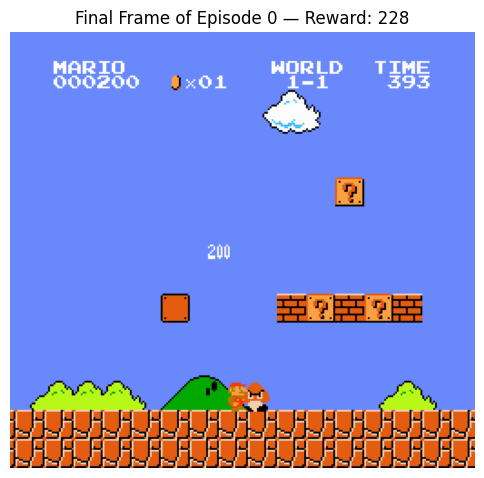

Total reward: 228.0 Epsilon: 0.9999980000017499 Size of replay buffer: 39 Learn step counter: 8
Total reward: 228.0
Episode: 1
 Episode 1 finished with reward: 607.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 100, 'stage': 1, 'status': 'small', 'time': 381, 'world': 1, 'x_pos': 683, 'y_pos': 79}


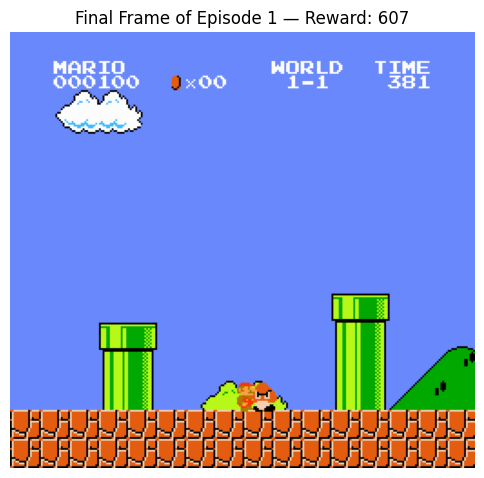

Total reward: 607.0 Epsilon: 0.9999740003347434 Size of replay buffer: 135 Learn step counter: 104
Total reward: 607.0
Episode: 2
 Episode 2 finished with reward: 635.0
Episode End Info: {'coins': 2, 'flag_get': False, 'life': 2, 'score': 500, 'stage': 1, 'status': 'small', 'time': 368, 'world': 1, 'x_pos': 722, 'y_pos': 79}


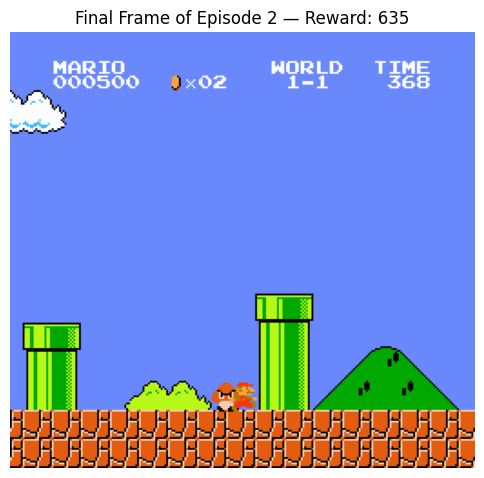

Total reward: 635.0 Epsilon: 0.9999337521861927 Size of replay buffer: 296 Learn step counter: 265
Total reward: 635.0
Episode: 3
 Episode 3 finished with reward: 581.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 381, 'world': 1, 'x_pos': 656, 'y_pos': 79}


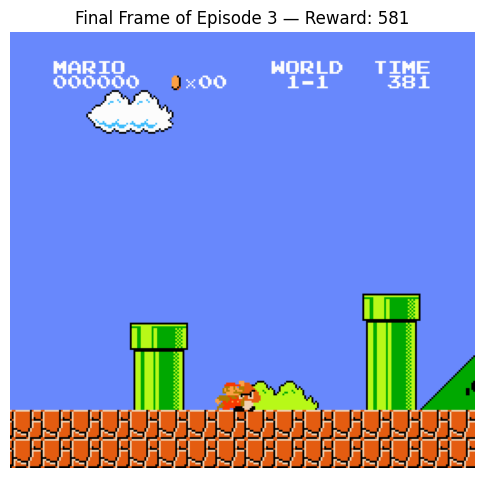

Total reward: 581.0 Epsilon: 0.999909254106301 Size of replay buffer: 394 Learn step counter: 363
Total reward: 581.0
Episode: 4
 Episode 4 finished with reward: 252.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 394, 'world': 1, 'x_pos': 315, 'y_pos': 79}


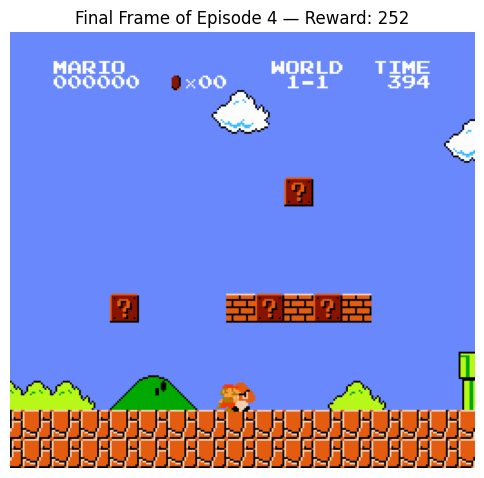

Total reward: 252.0 Epsilon: 0.999900754912699 Size of replay buffer: 428 Learn step counter: 397
Total reward: 252.0
Episode: 5
 Episode 5 finished with reward: 993.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 322, 'world': 1, 'x_pos': 1127, 'y_pos': 253}


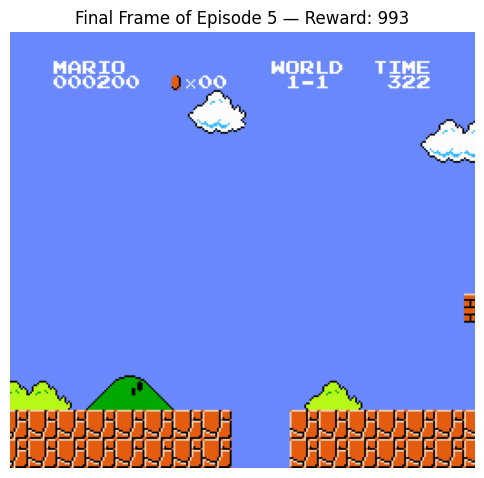

Total reward: 993.0 Epsilon: 0.9998020195759326 Size of replay buffer: 823 Learn step counter: 792
Total reward: 993.0
Episode: 6
 Episode 6 finished with reward: 248.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 394, 'world': 1, 'x_pos': 311, 'y_pos': 79}


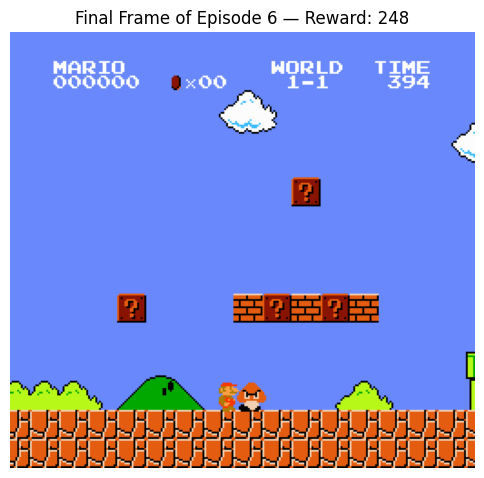

Total reward: 248.0 Epsilon: 0.9997937712422633 Size of replay buffer: 856 Learn step counter: 825
Total reward: 248.0
Episode: 7
 Episode 7 finished with reward: 650.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 296, 'world': 1, 'x_pos': 812, 'y_pos': 79}


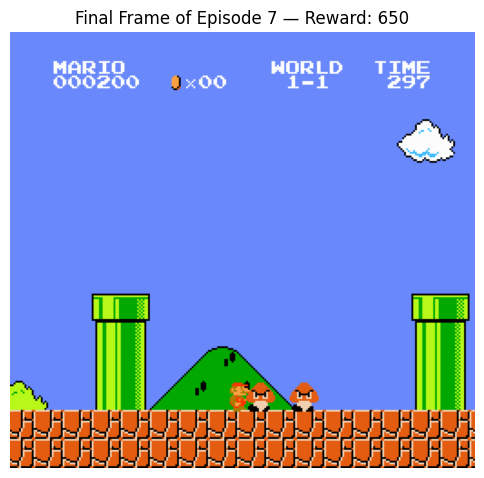

Total reward: 650.0 Epsilon: 0.9996638064836307 Size of replay buffer: 1376 Learn step counter: 1345
Total reward: 650.0
Episode: 8
 Episode 8 finished with reward: 247.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 394, 'world': 1, 'x_pos': 310, 'y_pos': 79}


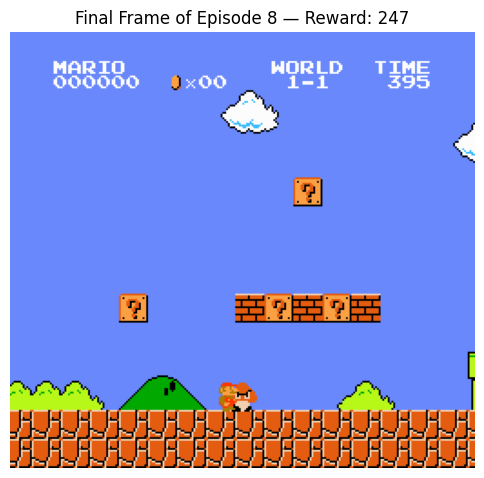

Total reward: 247.0 Epsilon: 0.9996563090322593 Size of replay buffer: 1406 Learn step counter: 1375
Total reward: 247.0
Episode: 9
 Episode 9 finished with reward: 772.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 400, 'stage': 1, 'status': 'small', 'time': 329, 'world': 1, 'x_pos': 898, 'y_pos': 79}


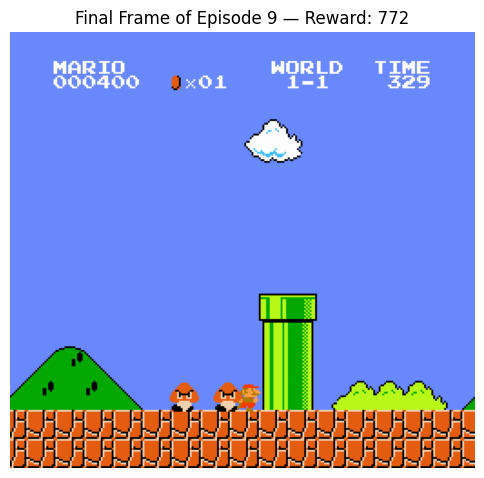

Total reward: 772.0 Epsilon: 0.9995673435686441 Size of replay buffer: 1762 Learn step counter: 1731
Total reward: 772.0
Episode: 10
 Episode 10 finished with reward: 612.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 100, 'stage': 1, 'status': 'small', 'time': 381, 'world': 1, 'x_pos': 688, 'y_pos': 79}


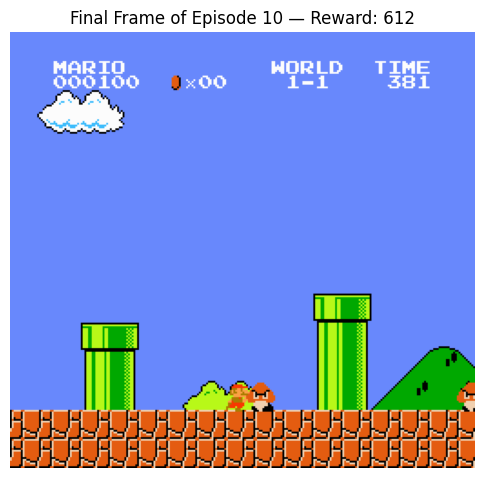

Total reward: 612.0 Epsilon: 0.9995433542372696 Size of replay buffer: 1858 Learn step counter: 1827
Total reward: 612.0
Episode: 11
 Episode 11 finished with reward: 237.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 393, 'world': 1, 'x_pos': 301, 'y_pos': 79}


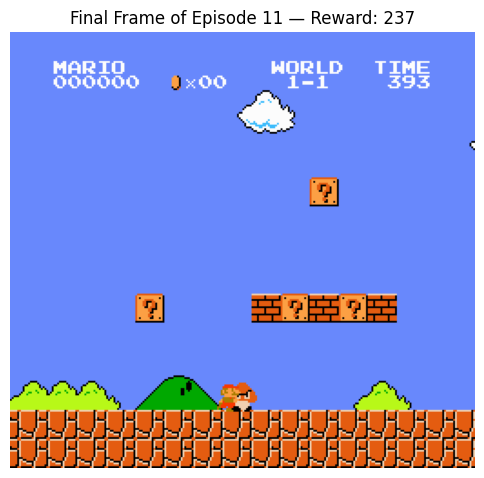

Total reward: 237.0 Epsilon: 0.9995338586193204 Size of replay buffer: 1896 Learn step counter: 1865
Total reward: 237.0
Episode: 12
 Episode 12 finished with reward: 229.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 392, 'world': 1, 'x_pos': 294, 'y_pos': 85}


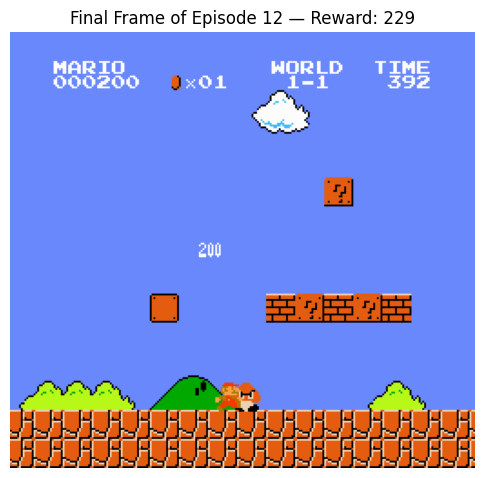

Total reward: 229.0 Epsilon: 0.9995231136867497 Size of replay buffer: 1939 Learn step counter: 1908
Total reward: 229.0
Episode: 13
 Episode 13 finished with reward: 1071.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 500, 'stage': 1, 'status': 'small', 'time': 112, 'world': 1, 'x_pos': 1414, 'y_pos': 252}


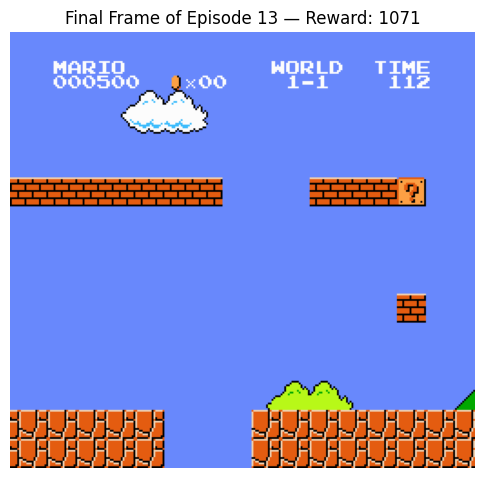

Total reward: 1071.0 Epsilon: 0.9991623509191615 Size of replay buffer: 3383 Learn step counter: 3352
Total reward: 1071.0
Episode: 14
 Episode 14 finished with reward: 639.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 100, 'stage': 1, 'status': 'small', 'time': 372, 'world': 1, 'x_pos': 722, 'y_pos': 79}


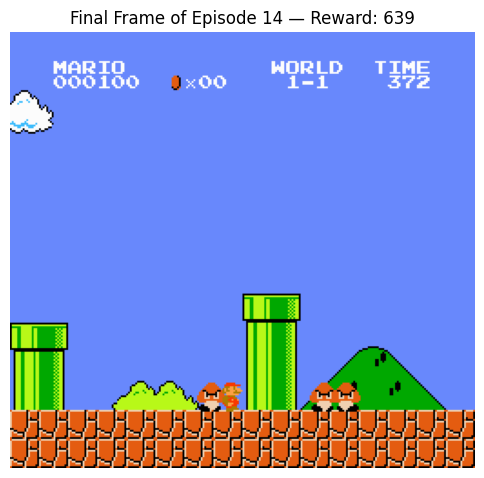

Total reward: 639.0 Epsilon: 0.9991263817174767 Size of replay buffer: 3527 Learn step counter: 3496
Total reward: 639.0
Episode: 15
 Episode 15 finished with reward: 721.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 300, 'stage': 1, 'status': 'small', 'time': 328, 'world': 1, 'x_pos': 851, 'y_pos': 79}


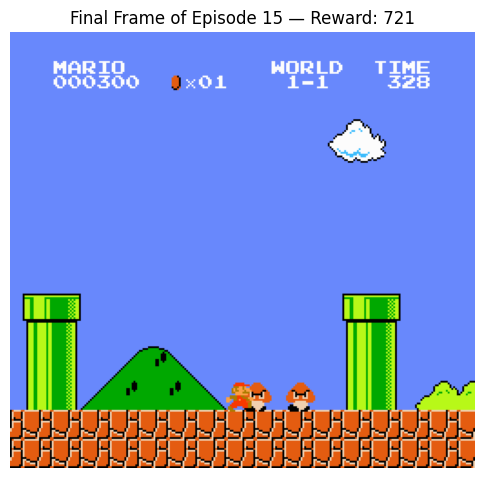

Total reward: 721.0 Epsilon: 0.9990364643782108 Size of replay buffer: 3887 Learn step counter: 3856
Total reward: 721.0
Episode: 16
 Episode 16 finished with reward: 695.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 300, 'stage': 1, 'status': 'small', 'time': 252, 'world': 1, 'x_pos': 898, 'y_pos': 79}


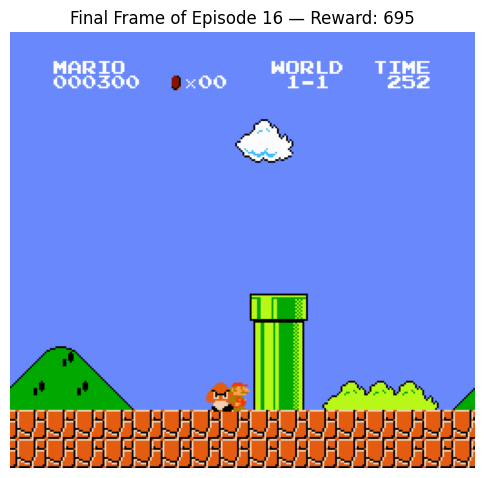

Total reward: 695.0 Epsilon: 0.9988514099912192 Size of replay buffer: 4628 Learn step counter: 4597
Total reward: 695.0
Episode: 17
 Episode 17 finished with reward: 1300.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 100, 'stage': 1, 'status': 'small', 'time': 348, 'world': 1, 'x_pos': 1409, 'y_pos': 254}


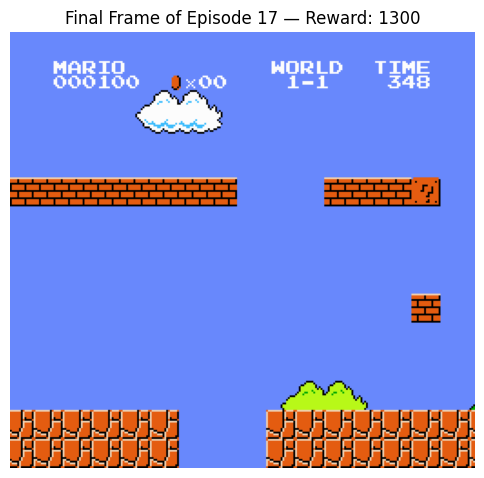

Total reward: 1300.0 Epsilon: 0.9987857376617953 Size of replay buffer: 4891 Learn step counter: 4860
Total reward: 1300.0
Episode: 18
 Episode 18 finished with reward: 749.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 300, 'stage': 1, 'status': 'small', 'time': 306, 'world': 1, 'x_pos': 898, 'y_pos': 84}


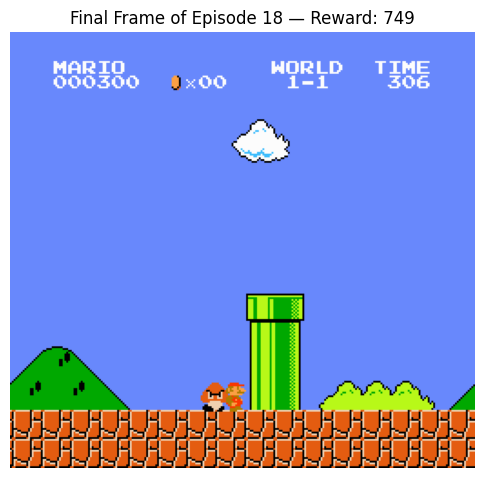

Total reward: 749.0 Epsilon: 0.9986681375503119 Size of replay buffer: 5362 Learn step counter: 5331
Total reward: 749.0
Episode: 19
 Episode 19 finished with reward: 855.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 600, 'stage': 1, 'status': 'small', 'time': 181, 'world': 1, 'x_pos': 1130, 'y_pos': 253}


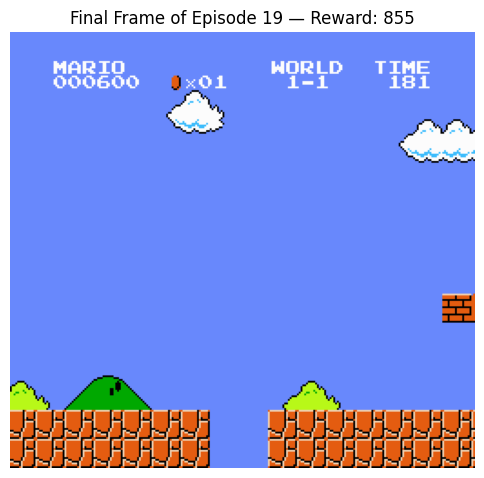

Total reward: 855.0 Epsilon: 0.9983937911352526 Size of replay buffer: 6461 Learn step counter: 6430
Total reward: 855.0
Episode: 20
 Episode 20 finished with reward: 242.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 394, 'world': 1, 'x_pos': 306, 'y_pos': 85}


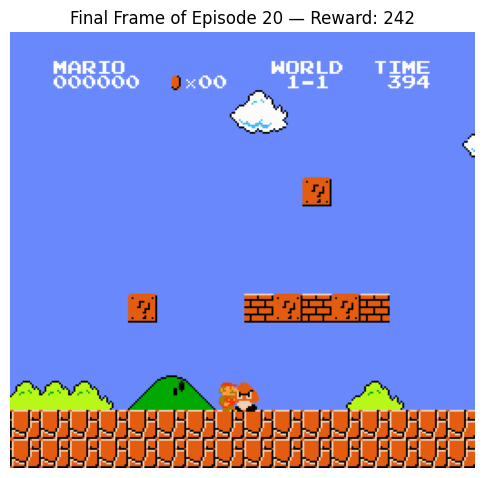

Total reward: 242.0 Epsilon: 0.9983858040158725 Size of replay buffer: 6493 Learn step counter: 6462
Total reward: 242.0
Episode: 21
 Episode 21 finished with reward: 241.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 394, 'world': 1, 'x_pos': 305, 'y_pos': 79}


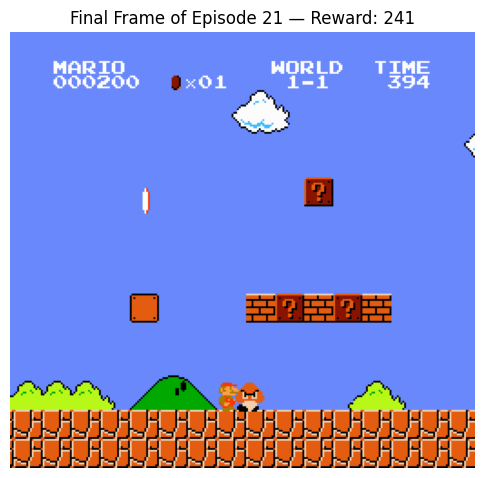

Total reward: 241.0 Epsilon: 0.9983773177715428 Size of replay buffer: 6527 Learn step counter: 6496
Total reward: 241.0
Episode: 22
 Episode 22 finished with reward: 237.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 392, 'world': 1, 'x_pos': 303, 'y_pos': 79}


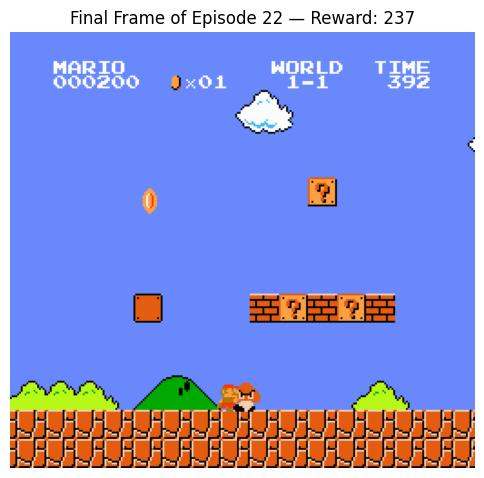

Total reward: 237.0 Epsilon: 0.9983670844552013 Size of replay buffer: 6568 Learn step counter: 6537
Total reward: 237.0
Episode: 23
 Episode 23 finished with reward: 603.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 300, 'stage': 1, 'status': 'small', 'time': 366, 'world': 1, 'x_pos': 693, 'y_pos': 79}


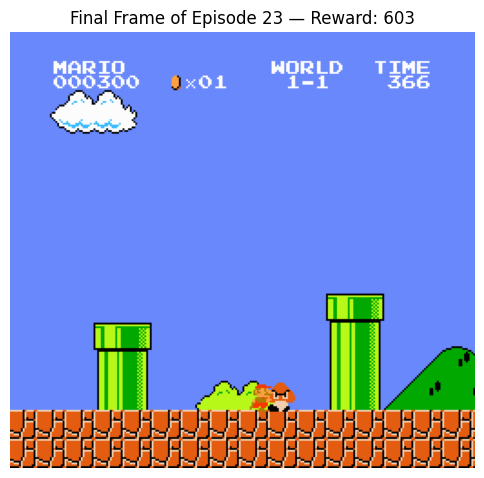

Total reward: 603.0 Epsilon: 0.9983246547504402 Size of replay buffer: 6738 Learn step counter: 6707
Total reward: 603.0
Episode: 24
 Episode 24 finished with reward: 623.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 300, 'stage': 1, 'status': 'small', 'time': 356, 'world': 1, 'x_pos': 722, 'y_pos': 79}


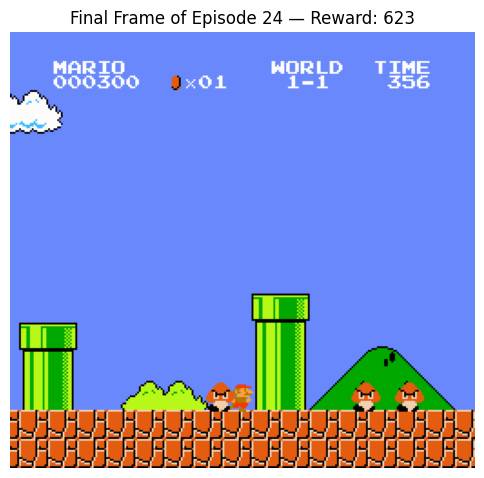

Total reward: 623.0 Epsilon: 0.99826899969537 Size of replay buffer: 6961 Learn step counter: 6930
Total reward: 623.0
Episode: 25
 Episode 25 finished with reward: 525.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 82, 'world': 1, 'x_pos': 898, 'y_pos': 79}


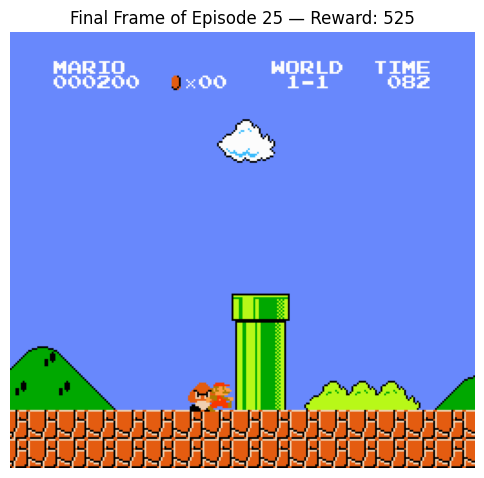

Total reward: 525.0 Epsilon: 0.9978720171062081 Size of replay buffer: 8552 Learn step counter: 8521
Total reward: 525.0
Episode: 26
 Episode 26 finished with reward: 242.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 393, 'world': 1, 'x_pos': 306, 'y_pos': 79}


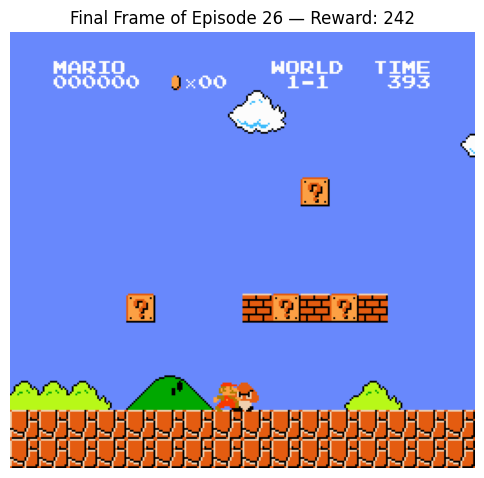

Total reward: 242.0 Epsilon: 0.9978625373658876 Size of replay buffer: 8590 Learn step counter: 8559
Total reward: 242.0
Episode: 27
 Episode 27 finished with reward: 573.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 300, 'stage': 1, 'status': 'small', 'time': 210, 'world': 1, 'x_pos': 821, 'y_pos': 79}


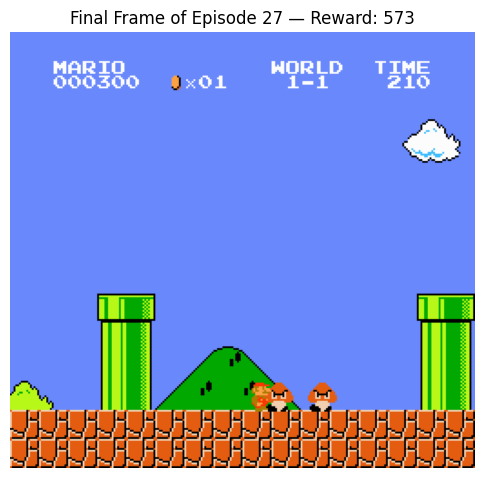

Total reward: 573.0 Epsilon: 0.9976250743115023 Size of replay buffer: 9542 Learn step counter: 9511
Total reward: 573.0
Episode: 28
 Episode 28 finished with reward: 740.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 367, 'world': 1, 'x_pos': 830, 'y_pos': 79}


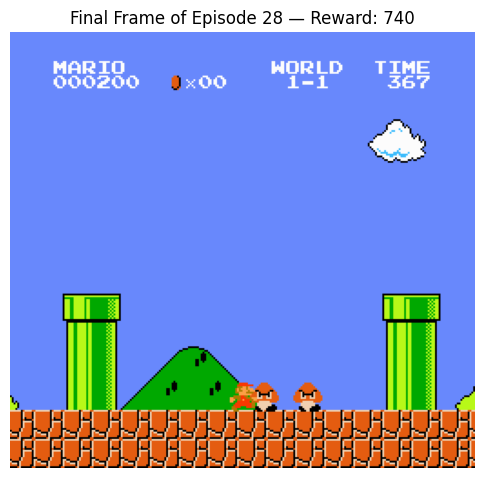

Total reward: 740.0 Epsilon: 0.9975834243288871 Size of replay buffer: 9709 Learn step counter: 9678
Total reward: 740.0
Episode: 29
 Episode 29 finished with reward: 789.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 346, 'world': 1, 'x_pos': 898, 'y_pos': 79}


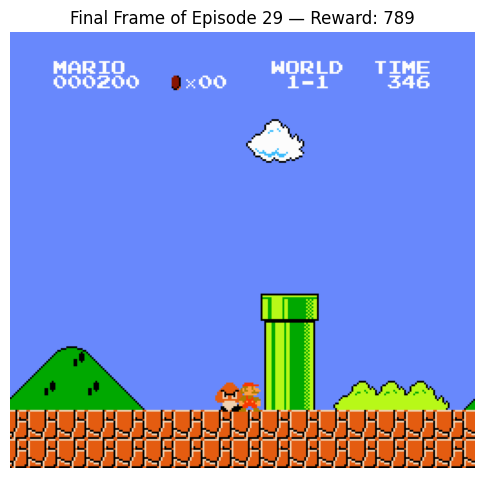

Total reward: 789.0 Epsilon: 0.9975150921961722 Size of replay buffer: 9983 Learn step counter: 9952
Total reward: 789.0
Episode: 30
 Episode 30 finished with reward: 959.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 500, 'stage': 1, 'status': 'small', 'time': 290, 'world': 1, 'x_pos': 1124, 'y_pos': 255}


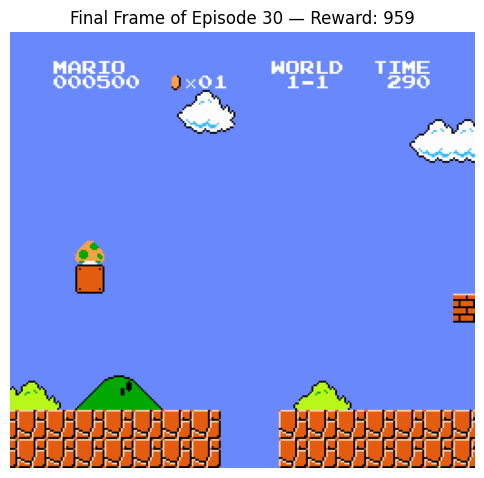

Total reward: 959.0 Epsilon: 0.9973769459054672 Size of replay buffer: 10537 Learn step counter: 10506
Total reward: 959.0
Episode: 31
 Episode 31 finished with reward: 606.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 300, 'stage': 1, 'status': 'small', 'time': 385, 'world': 1, 'x_pos': 679, 'y_pos': 79}


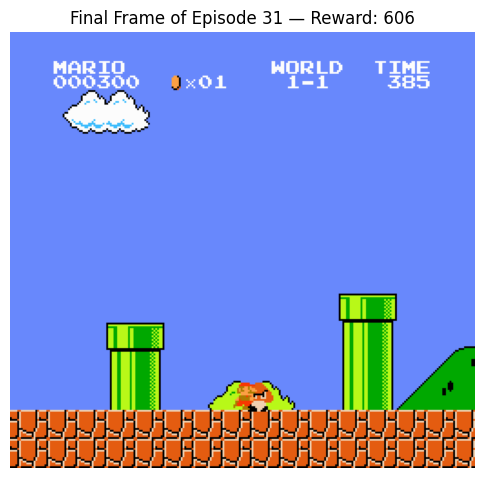

Total reward: 606.0 Epsilon: 0.9973579959211492 Size of replay buffer: 10613 Learn step counter: 10582
Total reward: 606.0
Episode: 32
 Episode 32 finished with reward: 249.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 395, 'world': 1, 'x_pos': 312, 'y_pos': 79}


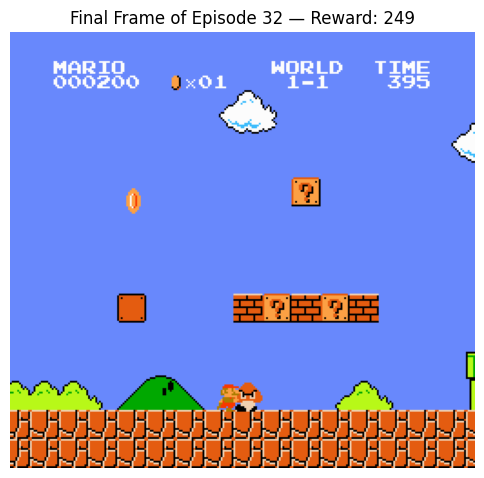

Total reward: 249.0 Epsilon: 0.9973507651009856 Size of replay buffer: 10642 Learn step counter: 10611
Total reward: 249.0
Episode: 33
 Episode 33 finished with reward: 241.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 394, 'world': 1, 'x_pos': 304, 'y_pos': 79}


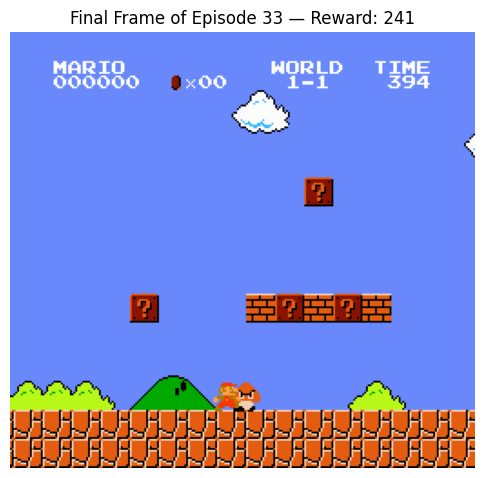

Total reward: 241.0 Epsilon: 0.9973425369900849 Size of replay buffer: 10675 Learn step counter: 10644
Total reward: 241.0
Episode: 34
 Episode 34 finished with reward: 593.0
Episode End Info: {'coins': 2, 'flag_get': False, 'life': 2, 'score': 400, 'stage': 1, 'status': 'small', 'time': 373, 'world': 1, 'x_pos': 678, 'y_pos': 79}


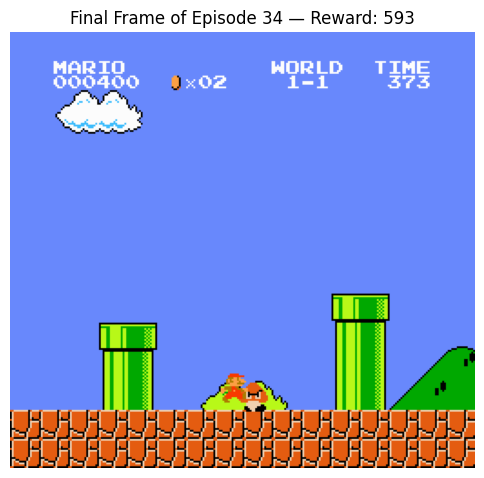

Total reward: 593.0 Epsilon: 0.9973083785888843 Size of replay buffer: 10812 Learn step counter: 10781
Total reward: 593.0
Episode: 35
 Episode 35 finished with reward: 910.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 400, 'stage': 1, 'status': 'small', 'time': 230, 'world': 1, 'x_pos': 1137, 'y_pos': 255}


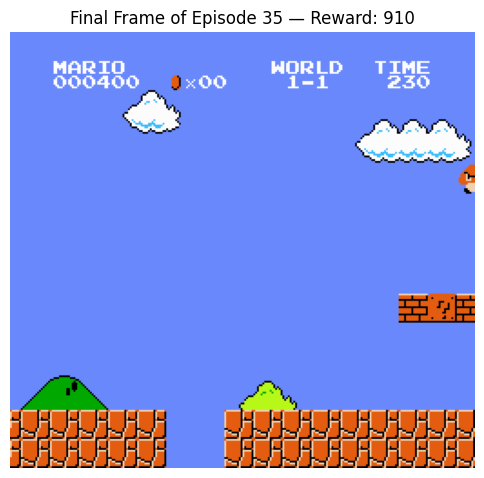

Total reward: 910.0 Epsilon: 0.9970962237735598 Size of replay buffer: 11663 Learn step counter: 11632
Total reward: 910.0
Episode: 36
 Episode 36 finished with reward: 235.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 392, 'world': 1, 'x_pos': 301, 'y_pos': 79}


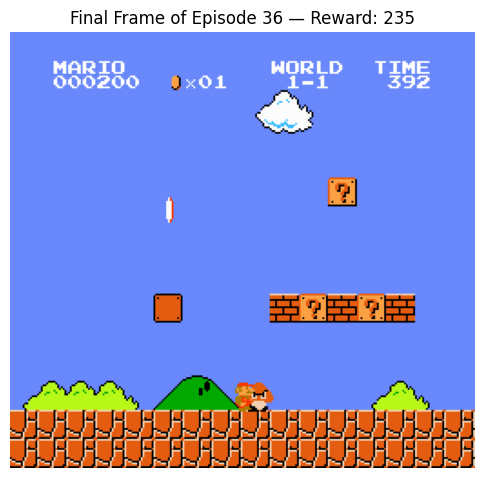

Total reward: 235.0 Epsilon: 0.9970857543168647 Size of replay buffer: 11705 Learn step counter: 11674
Total reward: 235.0
Episode: 37
 Episode 37 finished with reward: 731.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 288, 'world': 1, 'x_pos': 898, 'y_pos': 79}


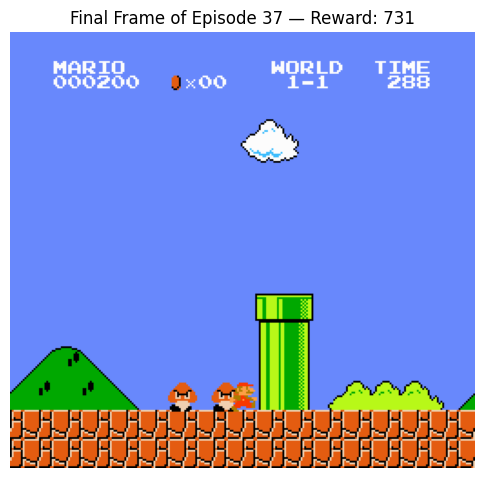

Total reward: 731.0 Epsilon: 0.9969451751189797 Size of replay buffer: 12269 Learn step counter: 12238
Total reward: 731.0
Episode: 38
 Episode 38 finished with reward: 1113.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 400, 'stage': 1, 'status': 'small', 'time': 163, 'world': 1, 'x_pos': 1407, 'y_pos': 255}


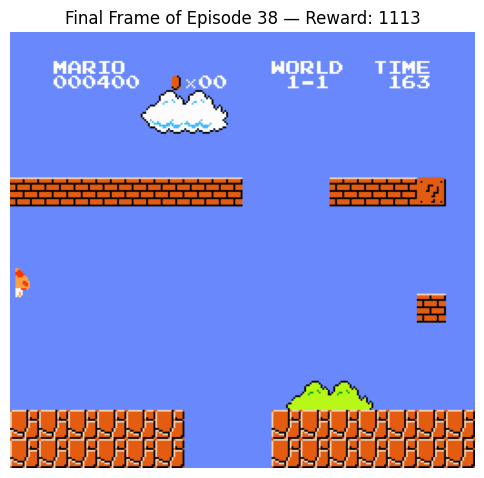

Total reward: 1113.0 Epsilon: 0.9966493754926871 Size of replay buffer: 13456 Learn step counter: 13425
Total reward: 1113.0
Episode: 39
 Episode 39 finished with reward: 872.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 100, 'stage': 1, 'status': 'small', 'time': 199, 'world': 1, 'x_pos': 1130, 'y_pos': 255}


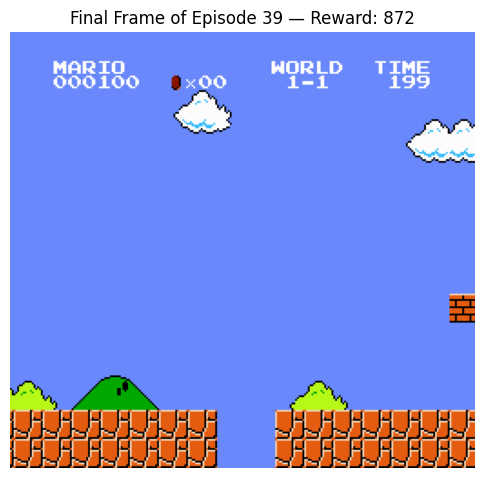

Total reward: 872.0 Epsilon: 0.9963987496609069 Size of replay buffer: 14462 Learn step counter: 14431
Total reward: 872.0
Episode: 40
 Episode 40 finished with reward: 233.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 393, 'world': 1, 'x_pos': 297, 'y_pos': 79}


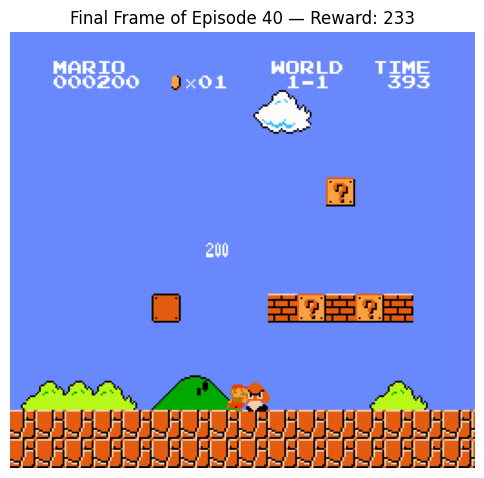

Total reward: 233.0 Epsilon: 0.996389034819242 Size of replay buffer: 14501 Learn step counter: 14470
Total reward: 233.0
Episode: 41
 Episode 41 finished with reward: 1262.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 300, 'stage': 1, 'status': 'small', 'time': 285, 'world': 1, 'x_pos': 1435, 'y_pos': 253}


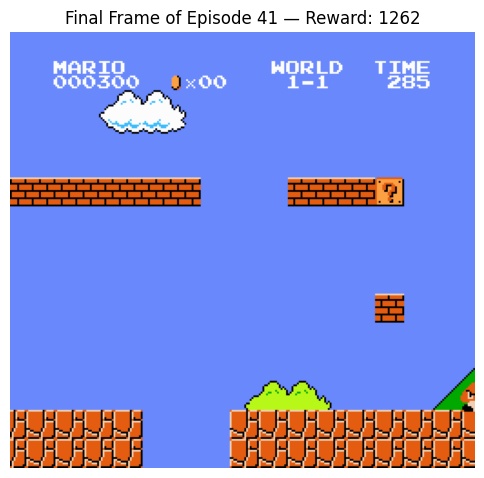

Total reward: 1262.0 Epsilon: 0.9962450669876209 Size of replay buffer: 15079 Learn step counter: 15048
Total reward: 1262.0
Episode: 42
 Episode 42 finished with reward: 940.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 300, 'stage': 1, 'status': 'small', 'time': 271, 'world': 1, 'x_pos': 1124, 'y_pos': 253}


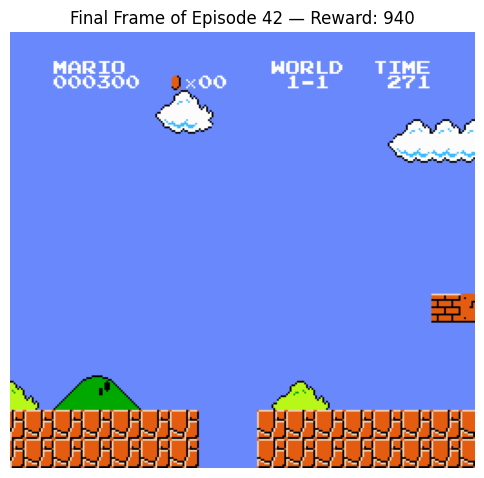

Total reward: 940.0 Epsilon: 0.9960836883385973 Size of replay buffer: 15727 Learn step counter: 15696
Total reward: 940.0
Episode: 43
 Episode 43 finished with reward: 246.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 394, 'world': 1, 'x_pos': 310, 'y_pos': 79}


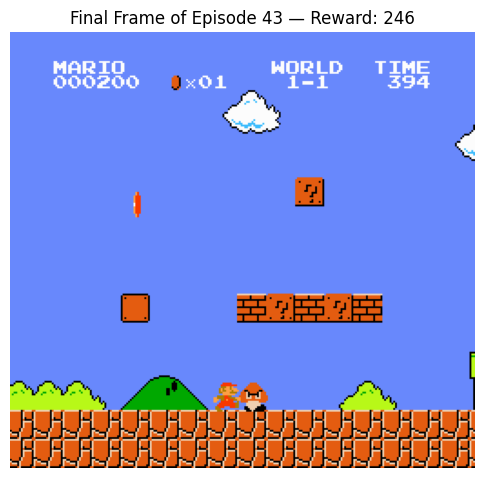

Total reward: 246.0 Epsilon: 0.9960759687189602 Size of replay buffer: 15758 Learn step counter: 15727
Total reward: 246.0
Episode: 44
 Episode 44 finished with reward: 237.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 393, 'world': 1, 'x_pos': 302, 'y_pos': 85}


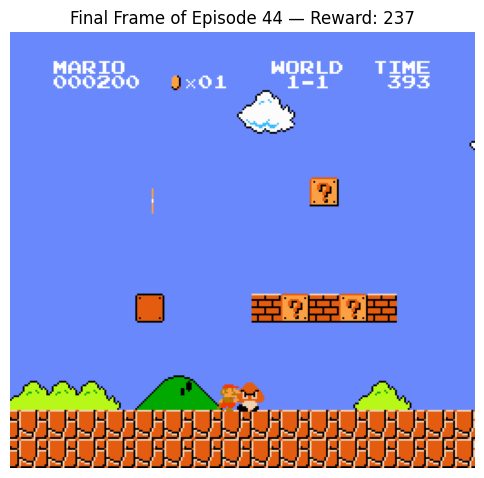

Total reward: 237.0 Epsilon: 0.996066506041021 Size of replay buffer: 15796 Learn step counter: 15765
Total reward: 237.0
Episode: 45
 Episode 45 finished with reward: 792.0
Episode End Info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 100, 'stage': 1, 'status': 'small', 'time': 349, 'world': 1, 'x_pos': 898, 'y_pos': 79}


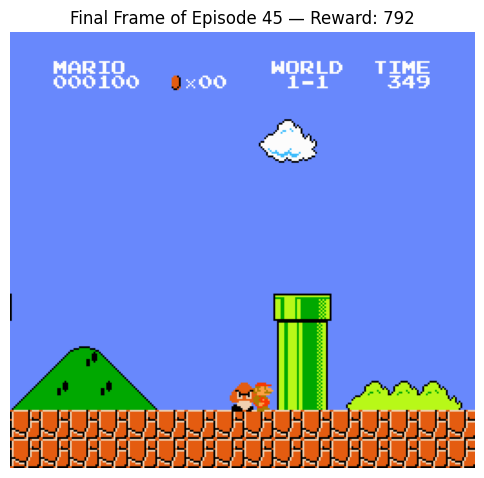

Total reward: 792.0 Epsilon: 0.9960020128146748 Size of replay buffer: 16055 Learn step counter: 16024
Total reward: 792.0
Episode: 46
 Episode 46 finished with reward: 251.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 395, 'world': 1, 'x_pos': 314, 'y_pos': 79}


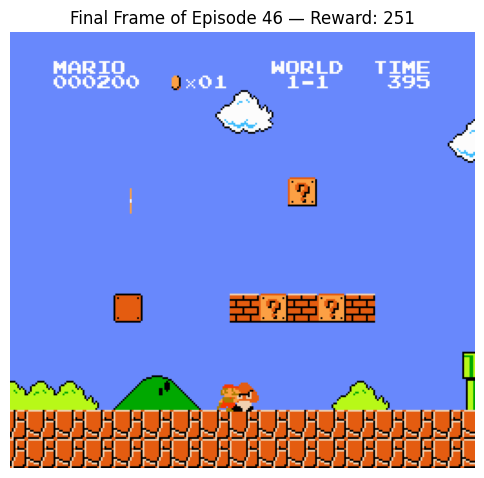

Total reward: 251.0 Epsilon: 0.9959945428266563 Size of replay buffer: 16085 Learn step counter: 16054
Total reward: 251.0
Episode: 47
 Episode 47 finished with reward: 976.0
Episode End Info: {'coins': 2, 'flag_get': False, 'life': 2, 'score': 600, 'stage': 1, 'status': 'small', 'time': 307, 'world': 1, 'x_pos': 1124, 'y_pos': 254}


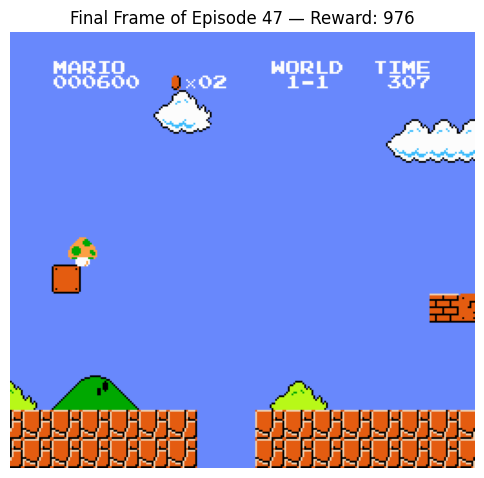

Total reward: 976.0 Epsilon: 0.9958782672369505 Size of replay buffer: 16552 Learn step counter: 16521
Total reward: 976.0
Episode: 48
 Episode 48 finished with reward: 1594.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 900, 'stage': 1, 'status': 'small', 'time': 261, 'world': 1, 'x_pos': 1790, 'y_pos': 91}


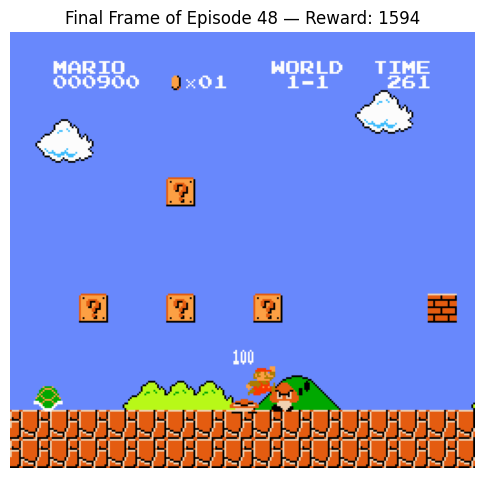

Total reward: 1594.0 Epsilon: 0.9957045016190638 Size of replay buffer: 17250 Learn step counter: 17219
Total reward: 1594.0
Episode: 49
 Episode 49 finished with reward: 235.0
Episode End Info: {'coins': 1, 'flag_get': False, 'life': 2, 'score': 200, 'stage': 1, 'status': 'small', 'time': 392, 'world': 1, 'x_pos': 301, 'y_pos': 79}


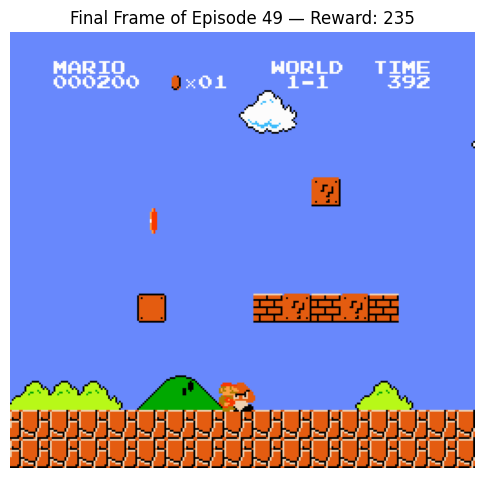

Total reward: 235.0 Epsilon: 0.9956937978518648 Size of replay buffer: 17293 Learn step counter: 17262
Total reward: 235.0


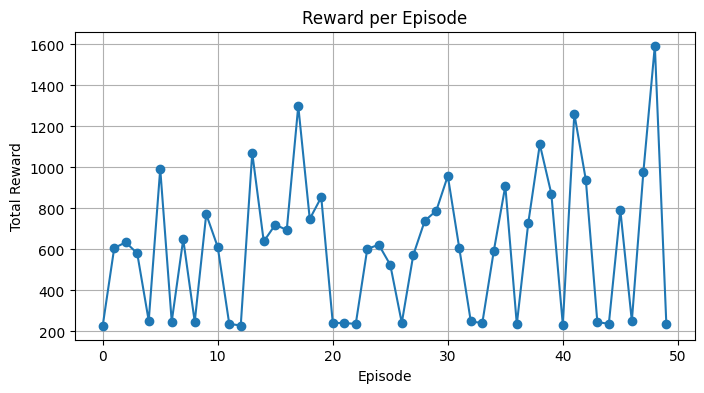

In [21]:
#main.py



import torch

import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY

# from agent import Agent

from nes_py.wrappers import JoypadSpace
# from wrappers import apply_wrappers

import os

import matplotlib.pyplot as plt
from IPython import display

from PIL import Image

# from utils import *

model_path = os.path.join("models", get_current_date_time_string())
os.makedirs(model_path, exist_ok=True)

if torch.cuda.is_available():
    print("Using CUDA device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available")

ENV_NAME = 'SuperMarioBros-1-1-v0'
SHOULD_TRAIN = True
DISPLAY = True
CKPT_SAVE_INTERVAL = 10
NUM_OF_EPISODES = 50

# env = gym_super_mario_bros.make(ENV_NAME, render_mode='human' if DISPLAY else 'rgb', apply_api_compatibility=True)

#Renders each frame as an image (an RGB NumPy array).
# Use Case: Useful for saving videos, feeding images to a neural net (e.g., in CNNs), or visualizing later.
# Output: Returns a NumPy array of shape (H, W, 3) representing the frame.
# Performance: More flexible and faster if you’re not displaying in real-time.

#render mode humans: Slower because it involves graphical display. Best for humans to watch what the agent is doing in real time.

env = gym_super_mario_bros.make(ENV_NAME, render_mode='rgb_array', apply_api_compatibility=True)

env = JoypadSpace(env, RIGHT_ONLY)

env = apply_wrappers(env)

agent = Agent(input_dims=env.observation_space.shape, num_actions=env.action_space.n)

if not SHOULD_TRAIN:
    folder_name = ""
    ckpt_name = ""
    agent.load_model(os.path.join("models", folder_name, ckpt_name))
    agent.epsilon = 0.2
    agent.eps_min = 0.0
    agent.eps_decay = 0.0

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)



rewards_per_episode = []

for i in range(NUM_OF_EPISODES):    
    print("Episode:", i)
    done = False
    state, _ = env.reset()
    total_reward = 0
    
    
    
    
    episode_frames = []  # store all frames in this episode

    while not done:
        a = agent.choose_action(state)
        new_state, reward, done, truncated, info = env.step(a)
        total_reward += reward

        # Store frame to show at end of episode
        frame = env.render()
        episode_frames.append(frame)

        if SHOULD_TRAIN:
            agent.store_in_memory(state, a, reward, new_state, done)
            agent.learn()

        state = new_state
    
    # Print total reward after episode
    print(f" Episode {i} finished with reward: {total_reward}")
    
    rewards_per_episode.append(total_reward)
    
    print("Episode End Info:", info)



    # Show last frame from episode
    if len(episode_frames) > 0:
        plt.figure(figsize=(6, 6))
        plt.imshow(episode_frames[-1])
        plt.axis("off")
        plt.title(f"Final Frame of Episode {i} — Reward: {int(total_reward)}")
        display.display(plt.gcf())  
        plt.close()
        
        
        # Save final frame as PNG
        
        Image.fromarray(episode_frames[-1]).save(f"episode_{i}_final.png")
    

    print("Total reward:", total_reward, "Epsilon:", agent.epsilon, 
          "Size of replay buffer:", len(agent.replay_buffer), 
          "Learn step counter:", agent.learn_step_counter)

    if SHOULD_TRAIN and (i + 1) % CKPT_SAVE_INTERVAL == 0:
        agent.save_model(os.path.join(model_path, "model_" + str(i + 1) + "_iter.pt"))

    print("Total reward:", total_reward)


env.close()




# Plot reward trend across episodes
plt.figure(figsize=(8, 4))
plt.plot(rewards_per_episode, marker='o')
plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()





#For stage 2:

# import torch

# import gym_super_mario_bros
# from gym_super_mario_bros.actions import RIGHT_ONLY

# from agent import Agent

# from nes_py.wrappers import JoypadSpace
# from wrappers import apply_wrappers

# import os

# import matplotlib.pyplot as plt
# from IPython import display

# from PIL import Image

# from utils import *

# model_path = os.path.join("models", get_current_date_time_string())
# os.makedirs(model_path, exist_ok=True)

# if torch.cuda.is_available():
#     print("Using CUDA device:", torch.cuda.get_device_name(0))
# else:
#     print("CUDA is not available")

# ENV_NAME = 'SuperMarioBros-1-2-v0'
# SHOULD_TRAIN = True
# DISPLAY = True
# CKPT_SAVE_INTERVAL = 10
# NUM_OF_EPISODES = 5_0


# env = gym_super_mario_bros.make(ENV_NAME, render_mode='rgb_array', apply_api_compatibility=True)

# env = JoypadSpace(env, RIGHT_ONLY)

# env = apply_wrappers(env)

# agent = Agent(input_dims=env.observation_space.shape, num_actions=env.action_space.n)

# if not SHOULD_TRAIN:
#     folder_name = ""
#     ckpt_name = ""
#     agent.load_model(os.path.join("models", folder_name, ckpt_name))
#     agent.epsilon = 0.2
#     agent.eps_min = 0.0
#     agent.eps_decay = 0.0

# env.reset()
# next_state, reward, done, trunc, info = env.step(action=0)



# rewards_per_episode = []

# for i in range(NUM_OF_EPISODES):    
#     print("Episode:", i)
#     done = False
#     state, _ = env.reset()
#     total_reward = 0
    
    
    
    
#     episode_frames = []  # store all frames in this episode

#     while not done:
#         a = agent.choose_action(state)
#         new_state, reward, done, truncated, info = env.step(a)
#         total_reward += reward

#         # Store frame to show at end of episode
#         frame = env.render()
#         episode_frames.append(frame)

#         if SHOULD_TRAIN:
#             agent.store_in_memory(state, a, reward, new_state, done)
#             agent.learn()

#         state = new_state
    
#     # Print total reward after episode
#     print(f" Episode {i} finished with reward: {total_reward}")
    
#     rewards_per_episode.append(total_reward)
    
#     print("Episode End Info:", info)



#     # Show last frame from episode
#     if len(episode_frames) > 0:
#         plt.figure(figsize=(6, 6))
#         plt.imshow(episode_frames[-1])
#         plt.axis("off")
#         plt.title(f"Final Frame of Episode {i} — Reward: {int(total_reward)}")
#         display.display(plt.gcf())  # Do NOT clear this output
#         plt.close()
        
        
#         # Save final frame as PNG
        
#         Image.fromarray(episode_frames[-1]).save(f"episode_{i}_final.png")
    

#     print("Total reward:", total_reward, "Epsilon:", agent.epsilon, 
#           "Size of replay buffer:", len(agent.replay_buffer), 
#           "Learn step counter:", agent.learn_step_counter)

#     if SHOULD_TRAIN and (i + 1) % CKPT_SAVE_INTERVAL == 0:
#         agent.save_model(os.path.join(model_path, "model_" + str(i + 1) + "_iter.pt"))

#     print("Total reward:", total_reward)


# env.close()




# # Plot reward trend across episodes
# plt.figure(figsize=(8, 4))
# plt.plot(rewards_per_episode, marker='o')
# plt.title("Reward per Episode")
# plt.xlabel("Episode")
# plt.ylabel("Total Reward")
# plt.grid(True)
# plt.show()





In [30]:
#generate_clips.py

import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
from nes_py.wrappers import JoypadSpace
# from agent import Agent

from gym import Wrapper
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack

import os
from PIL import Image

# Modified SkipFrame wrapper to log frames and actions
class SkipFrame(Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip
        self.counter = 0
        self.frames_log = []
        self.actions_log = []
    
    def step(self, action):
        total_reward = 0.0
        done = False
        for _ in range(self._skip):
            next_state, reward, done, trunc, info = self.env.step(action)
            self.frames_log.append(next_state.copy())
            self.actions_log.append(action)
            total_reward += reward
            if done:
                break
        return next_state, total_reward, done, trunc, info
    
    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)
        self.frames_log = [state.copy()]
        self.actions_log = [0]
        return state, info

def apply_wrappers(env):
    env = SkipFrame(env, skip=4)
    env = ResizeObservation(env, shape=84)
    env = GrayScaleObservation(env)
    env = FrameStack(env, num_stack=4, lz4_compress=True)
    return env


ENV_NAME = 'SuperMarioBros-1-1-v0'
NUM_OF_EPISODES = 2_0
# controllers = [Image.open(f"controllers/{i}.png") for i in range(5)]

env = gym_super_mario_bros.make(ENV_NAME, render_mode='rgb_array', apply_api_compatibility=True)
env = JoypadSpace(env, RIGHT_ONLY)
env = apply_wrappers(env)

agent = Agent(input_dims=env.observation_space.shape, num_actions=env.action_space.n)

agent.load_model("models/2025-07-31-10_50_26/model_10_iter.pt")

for i in range(NUM_OF_EPISODES):
    done = False
    state, _ = env.reset()
    rewards = 0
    while not done:
        action = agent.choose_action(state)
        frame = env.render()
        new_state, reward, done, truncated, info = env.step(action)
        rewards += reward

        # agent.store_in_memory(state, action, reward, new_state, done)
        # agent.learn()

        state = new_state

        if done:
            print(f"Episode: {i}, Reward: {rewards}")
            print("Flag Reached:", info.get("flag_get", False))

            # Always save episode frames
            os.makedirs(os.path.join("games", f"game_{i}"), exist_ok=True)
            frame_skip_env = env.env.env.env
            frames_log = frame_skip_env.frames_log
            actions_log = frame_skip_env.actions_log

            for j, (frame, action) in enumerate(zip(frames_log, actions_log)):
                scaling_factor = 10
                new_dims = (frame.shape[1] * scaling_factor, frame.shape[0] * scaling_factor)
                frame = Image.fromarray(frame).resize(new_dims, Image.NEAREST)
                frame.save(os.path.join("games", f"game_{i}", f"frame_{j}.png"))
env.close()



Episode: 0, Reward: 252.0
Flag Reached: False


/tmp/slurmtmp.36888087/ipykernel_876211/1791415054.py:89: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  frame = Image.fromarray(frame).resize(new_dims, Image.NEAREST)


Episode: 1, Reward: 233.0
Flag Reached: False
Episode: 2, Reward: 627.0
Flag Reached: False
Episode: 3, Reward: 242.0
Flag Reached: False
Episode: 4, Reward: 247.0
Flag Reached: False
Episode: 5, Reward: 637.0
Flag Reached: False
Episode: 6, Reward: 625.0
Flag Reached: False
Episode: 7, Reward: 620.0
Flag Reached: False
Episode: 8, Reward: 667.0
Flag Reached: False
Episode: 9, Reward: 772.0
Flag Reached: False
Episode: 10, Reward: 580.0
Flag Reached: False
Episode: 11, Reward: 236.0
Flag Reached: False
Episode: 12, Reward: 608.0
Flag Reached: False
Episode: 13, Reward: 632.0
Flag Reached: False
Episode: 14, Reward: 235.0
Flag Reached: False
Episode: 15, Reward: 242.0
Flag Reached: False
Episode: 16, Reward: 786.0
Flag Reached: False
Episode: 17, Reward: 600.0
Flag Reached: False
Episode: 18, Reward: 229.0
Flag Reached: False
Episode: 19, Reward: 618.0
Flag Reached: False


In [31]:
#Video representation of Mario-Bros playing the game finally
!cd games/game_1

In [32]:
!pip install imageio[ffmpeg]

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [37]:
import imageio
import os

image_folder = "games/game_19"
video_path = "games/videos/game_19.mp4"

images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")],
                key=lambda x: int(x.split('_')[1].split('.')[0]))

writer = imageio.get_writer(video_path, fps=60)

for img_name in images:
    img_path = os.path.join(image_folder, img_name)
    frame = imageio.imread(img_path)
    writer.append_data(frame)

writer.close()


/tmp/slurmtmp.36888087/ipykernel_876211/97127816.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(img_path)


In [38]:
print(f"Number of frames: {len(images)}")

Number of frames: 283


In [39]:
import imageio
import os

sizes = set()
for img in sorted(os.listdir(image_folder)):
    if img.endswith(".png"):
        img_path = os.path.join(image_folder, img)
        img_data = imageio.imread(img_path)
        sizes.add(img_data.shape)

print("Unique frame sizes:", sizes)


/tmp/slurmtmp.36888087/ipykernel_876211/2797380698.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_data = imageio.imread(img_path)


Unique frame sizes: {(2400, 2560, 3)}
